# Finding Similar Songs on Spotify - Part 2: Siamese Networks

In the first part of this tutorial I have introduced the traditional distance based approach to similarity estimations. The main idea is that features are extracted from the audio content. These features are numeric descriptions of semantically relevant information. An example for a high-level feature is the number of beats per minute which is a description for the tempo of a song. Music feature-sets are more abstract and describe the spectral or rhythmical distribution of energy. These are not single but vectors of numbers. Thus, a song is semantically described by this vector and if the set of extracted features spans over various music characteristics such as rhythm, timbre, harmonics, complexity, etc. then calculating the similarity of the vector's numbers is considered to be an approximation of music similarity. Thus, the lower the numerical distance between two vectors, the higher their acoustic similarity. For this reason these approaches are known as *Distance based* methods. They mainly depend on the selected sets of features and on the similarity metric chosen to compare their values.

In the second part of this tutorial we are now focussing on an approach, where the feature representation, as well as the similarity function is learned from the underlying dataset.


## Tutorial Overview

1. Loading data
2. Preprocess data
3. Define Model
4. Fit Model
5. Evaluate Model



## Requiremnts

The requirements are the same as for the first part of the tutorials. Please follow the instructions of part one if you have trouble running this tutorial.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf

/home/schindler/anaconda/python2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from IPython.display import IFrame

# numeric and scientific processing
import numpy as np
import pandas as pd
from scipy.interpolate import RectBivariateSpline

# misc
import os
import progressbar

# spotify API
import spotipy
import spotipy.util as util

# local caching
from joblib import Memory

# functions from Tutorial Part 1
import tutorial_functions as tut_func

Using TensorFlow backend.


# Loading Data

We will use the same data that we downloaded from Spotify in Part 1 of the Tutorial. Because we used the joblib library, we will not have to wait that long, because the data is already cached on our harddrive.

Update the following two variables according the credentials you received from Spotify

In [3]:
SPOTIFY_USER = ""

os.environ["SPOTIPY_CLIENT_ID"]     = ""
os.environ["SPOTIPY_CLIENT_SECRET"] = ""

The same playlists as used in Part 1:

In [4]:
playlists = [
    
     {"name": "clubbeats",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DXbX3zSzB4MO0"},
     {"name": "softpop",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DWTwnEm1IYyoj"},
     {"name": "electropop",   "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4uPi2roRUwU"},
     {"name": "rockclassics", "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXRqgorJj26U"},
     {"name": "rockhymns",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4vth7idTQch"},
     {"name": "soft_rock",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX6xOPeSOGone"},
     {"name": "metalcore",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXIcbzpLauPS"}, 
     {"name": "metal",        "uri": "spotify:user:spotify:playlist:37i9dQZF1DWWOaP4H0w5b0"},
     {"name": "classic_metal","uri": "spotify:user:spotify:playlist:37i9dQZF1DX2LTcinqsO68"},
     {"name": "grunge",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DX11ghcIxjcjE"},
     {"name": "hiphop",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DWVdgXTbYm2r0"},
     {"name": "poppunk",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXa9wYJr1oMFq"},
     {"name": "classic",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXcN1fAVSf7CR"}
    
]

Connect to the Spotify API

In [5]:
token = util.prompt_for_user_token(SPOTIFY_USER, 
                                   "playlist-modify-public", 
                                   redirect_uri="http://localhost/")

sp = spotipy.Spotify(auth=token)

Define the local chache directory. This should be the same as in Part 1 of the tutorial.

In [6]:
memory = Memory(cachedir='/home/schindler/tmp/spotify/', verbose=0)

Unfortunately I was not able to move this function to the tutorial_functions.py file, due to the @memory annotation. (If you know a way how to solve this, please create a Github-issue with your solution).

In [7]:
@memory.cache
def get_spotify_data(track_id):
    
    # meta-data
    track_metadata      = sp.track(track_id)
    album_metadata      = sp.album(track_metadata["album"]["id"])
    artist_metadata     = sp.artist(track_metadata["artists"][0]["id"])
    
    # feature-data
    sequential_features = sp.audio_analysis(track_id)
    trackbased_features = sp.audio_features([track_id])
    
    return track_metadata, album_metadata, artist_metadata, sequential_features, trackbased_features

Start loading the Spotify Data

In [8]:
# Get Playlist meta-data
playlists = tut_func.get_playlist_metadata(sp, playlists)

# Get track-ids of all playlist entries
playlists = tut_func.get_track_ids(sp, playlists)

num_tracks_total = np.sum([playlist["num_tracks"] for playlist in playlists])

# Fetch data and features from Spotify
pbar = progressbar.ProgressBar(max_value=num_tracks_total)
pbar.start()

raw_track_data      = []
processed_track_ids = []

for playlist in playlists:

    for track_id in playlist["track_ids"]:

        try:
            # avoid duplicates in the data-set
            if track_id not in processed_track_ids:

                # retrieve data from Spotify
                spotify_data = get_spotify_data(track_id)

                raw_track_data.append([playlist["name"], spotify_data])
                processed_track_ids.append(track_id)

        except Exception as e:
            print(e)

        pbar.update(len(raw_track_data))

 98% (1059 of 1078) |#################### | Elapsed Time: 0:02:10 ETA:  0:00:03

### Aggregate feature-data

Currently we only have a list of raw data-objects retrieved from the Spotify API. We need to transform this information to a more structured format.

In [9]:
# Aggregate Meta-data
metadata = tut_func.aggregate_metadata(raw_track_data)

# Aggregate Feature-data
feature_data = tut_func.aggregate_featuredata(raw_track_data, metadata)

# standardize sequential_features
feature_data -= feature_data.mean(axis=0)
feature_data /= feature_data.std(axis=0)

# Siamese Networks

A Siamese neural network is a neural network architecture where two inputs are fed into the same stack of network layers. This is where the name comes from. The shared layers are "similar" to Siamese Twins. By feeding two inputs to the shared layers, two representations are generated which can be used for comparison. To train the network according a certain task, it requires labelled data. To learn a simlarity function, these labels should indicate if the two input are similar or dissimilar.

This is exactly the approach initially described by Hadsell-et-al.'06 (http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf). The authors create pairs of simlar and dissimilar images. These are fed into a Siamese NEtwork stack. Finally, the model calculates the eucledian distance between the two generated representations. A contrastive loss is used, to optimize the learned simlarity.

To calculate the similarity between a seed image and the rest of the collection, the model is applied to predict the distance between this seed image and every other. The result is a list of distances which has to be sorted descendingly.

The following code example follows this approach:

**Keras**

We use the high-level deep learning API Keras: https://keras.io/

In [10]:
from keras.models           import Model
from keras.layers           import Input, Lambda, Dense, Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.merge     import concatenate
from keras.optimizers       import Nadam
from keras import backend as K

First we define a distance measure to compare the two representations. We will be using the well known Eucledian distance:

In [11]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

### The Siamese Network Architecture

Now we define the Siamese Network Architecture. It consists of two fully connected layers. These layers are shared among the "Siamese twins". The network takes two inputs. One goes to the left twin, the other to the right one. The Eucledian distance of the output of each twin is calculated which is the final output of the model.

In [12]:
def create_siamese_network(input_dim):

    # input layers
    input_left  = Input(shape=input_dim)
    input_right = Input(shape=input_dim)

    # shared fully connected layers
    shared_fc_1 = Dense(100, activation="selu")
    shared_fc_2 = Dense(100, activation="selu")    
    
    # siamese layers
    left_twin  = shared_fc_1(shared_fc_2(input_left))
    right_twin = shared_fc_1(shared_fc_2(input_right))

    # calc difference
    distance = Lambda(euclidean_distance,
                      output_shape=lambda x: x[0])([left_twin, right_twin])

    return Model([input_left, input_right], distance)

**Contrastive Loss**

The contrastive loss is based on the Euclidean distance and measures the cost of data pairs. The objective of the contrastive loss is to minimize the distance between a similar pair and to separate any two dissimilar data with a distance margin

In [13]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

### Create Data-Pairs

Now we have to prepare and partition the input data. Because it is a pair-wise comparison approach, we have to create pairs of input instances. Especially, we will create sequences of genuine or similar pairs followed by impostor or dissimilar pairs.

In [14]:
def create_pairs(feature_data, metadata, num_pairs_per_track):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            
            # genuine pair
            data_pairs.append([feature_data[[row_id]][0], feature_data[[pos_example.index]][0]])
            labels.append(1)

            # impostor pair
            data_pairs.append([feature_data[[row_id]][0], feature_data[[neg_example.index]][0]])
            labels.append(0)

    return np.array(data_pairs), np.array(labels)

Exectue the function to prepare the input data

In [15]:
# create pairs
data_pairs, labels = create_pairs(feature_data, metadata, 10)

# check - how many instances have we created?
data_pairs.shape

(21200, 2, 69)

Prepare the Siamese Neural Network

In [16]:
# define the model
model_orig = create_siamese_network(data_pairs[:,0].shape[1:])

# define the optimizer
opt = Nadam(lr=0.001)

# compile the model
model_orig.compile(loss      = contrastive_loss, 
                   optimizer = opt)

Train the network

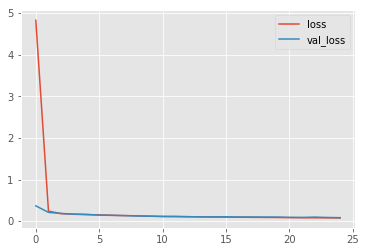

In [17]:
model_orig.fit([data_pairs[:, 0], data_pairs[:, 1]], 
                labels, 
                batch_size       = 24, 
                verbose          = 0, 
                epochs           = 25, 
                callbacks        = [tut_func.PlotLosses()], 
                validation_split = 0.1);

# Evaluate

Now that we have a trained model, we want to evaluate its performance. We will first play around with some examples, listen to the results and judge by our subjective interpretation before we persue a general evaluation.

### Evaluate by Example

The following function calculated the distances between a given query track and all other tracks of the collection. The result is a list of distances where the smallest distance coresponds with the most similar track. The list is sorted descendingly and the top-ten similar tracks are presented below the information of the query track. The Spotify playlist we created at the beginning will also be updated with the query results. Thus, you can listen to it in your Spotify client.

In [18]:
def similar(model, query_idx):
    
    print(metadata.iloc[query_idx])
    
    # calclulate predicted distances between query track and all others
    res = [model.predict([feature_data[[query_idx]], feature_data[[i]]]) for i in range(feature_data.shape[0])]

    # reshape
    res = np.array(res)
    res = res.reshape(res.shape[0])

    # get sorted indexes in ascending order (smallest distance to query track first)
    si = np.argsort(res)
    
    # output filter
    display_cols = ["artist_name", "title", "album_name", "year","playlist"]
    
    return metadata.loc[si, display_cols][:10]

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [19]:
similar(model_orig, 33)

track_id                                  637McrDyDQ9CffkFuZGRpq
artist_name                                                KSHMR
title                                                    Kolkata
album_name                                               Kolkata
label                                                     Dharma
duration                                                  206250
popularity                                                    54
year                                                        2017
genres         [big room, deep big room, edm, electro house, ...
playlist                                               clubbeats
Name: 33, dtype: object


,artist_name,title,album_name,year,playlist
33,KSHMR,Kolkata,Kolkata,2017,clubbeats
16,Hardwell,Get Low,Get Low,2018,clubbeats
9,Monik,Palkia,Palkia,2016,clubbeats
26,Noise Cans,No War (feat. Jesse Royal) - Yellow Claw Remix,No War (feat. Jesse Royal) [Yellow Claw Remix],2017,clubbeats
49,Calvin Logue,Warrior,Warrior EP,2018,clubbeats
70,Stadiumx,Spacebird,Spacebird,2017,clubbeats
8,Timmy Trumpet,Punjabi,Punjabi,2017,clubbeats
41,Tom & Jame,In The Air,In The Air,2017,clubbeats
37,Dropgun,Little Drop,Little Drop,2017,clubbeats
6,Don Diablo,Momentum,Momentum,2017,clubbeats


### General Evaluation

So far we have only tested our similarity retrieval algorithms on a few single examples. To evaluate, if the presented approaches perform differently, we perform a full evaluation. To estimate the performance we measure precision and recall of our algorithms. These are standard information retrieval measures of relevance. In the context of this tutorial **precision** measures how many tracks of a given resultlist belong to the same playlist as the query song (relative to the length of the resultlist). **Recall** measures how many tracks of the query song's playlist are contained in the resultlist (relative to the length of the playlist).

In [20]:
def evaluate(similarity_function, cut_off):

    all_precisions = []
    all_recall     = []

    for idx in metadata.index.values:

        dist           = similarity_function(feature_data, feature_data[[idx]])
        dist           = np.array(dist).reshape(len(dist))
        similar_tracks = metadata.loc[np.argsort(dist)[:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)

        recall = float(same_label.sum()) / metadata[metadata.playlist == metadata.loc[idx, "playlist"]].shape[0]
        all_recall.append(recall)

    all_precisions = np.array(all_precisions)
    all_recall     = np.array(recall)

    print("Precision", all_precisions.mean())
    print("Recall:",   all_recall.mean())

Run the evauation for the trained Siamese Network:

In [ ]:
evaluate(lambda x,y: [model_orig.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

### Discussion of Results

More than 90% precision is quite an exciting number, but several flaws of the experimental design have to be considered. The model is evaluated according its ability rank tracks higher which belong to the same playlist of the query track. This does not imply music similarity in general. The set of playlists used in this tutorial contains some very broad lists which span over several music genres. And even songs of the same genre may sound completely different.

The single exploratory examples show, that, althoug from the same playlist, many ranked results do not really fit.

# Improve Performance through prior Knowledge

The original approach only uses genuine and impostor pairs and does not consider any further prior knowledge. In that sense if two tracks belong to the same playlist, they are considered similar, if not, than they are not. But, because we have chosen genre-playlists, there are genres that are more similar than others. This is of course highly subjective and depends on the listening behaviour and experience of a listener.

The following list represents my own interpretation of genre similarities:

In [22]:
sim = [[["clubbeats",     "electropop"],    0.8],
       [["clubbeats",     "softpop"],       0.4],
       [["electropop",    "hiphop"],        0.4],
       [["softpop",       "soft_rock"],     0.2],
       [["softpop",       "electropop"],    0.4],
       [["softpop",       "hiphop"],        0.1],
       [["rockclassics",  "rockhymns"],     0.7],
       [["soft_rock",     "rockclassics"],  0.3],
       [["soft_rock",     "rockhymns"],     0.3],
       [["metalcore",     "metal"],         0.7],
       [["metalcore",     "classic_metal"], 0.6],
       [["metal",         "classic_metal"], 0.8],
       [["classic_metal", "grunge"],        0.5],
       [["metal",         "grunge"],        0.5],
       [["rockhymns",     "grunge"],        0.2],
       [["poppunk",       "metal"],         0.6],
       [["poppunk",       "classic_metal"], 0.4],
       [["poppunk",       "rockhymns"],     0.5],
       [["poppunk",       "rockclassics"],  0.4]]

The following code creates a symmetric lookup-table from the list above:

In [23]:
# get all playlist-names from our dataset
playlist_names = [pl["name"] for pl in playlists]

# create the lookup-table
playlist_similarities = pd.DataFrame(np.zeros((len(playlist_names),len(playlist_names))), 
                                     index   = playlist_names, 
                                     columns = playlist_names)

# self-similarity
for i in range(len(playlist_names)):
    for j in range(len(playlist_names)):
        if i == j:
            playlist_similarities.iloc[i,j] = 1.0

# genre-similarities
for s in sim:
    playlist_similarities.loc[s[0][0],s[0][1]] = s[1]
    playlist_similarities.loc[s[0][1],s[0][0]] = s[1]

# show results
playlist_similarities

,clubbeats,softpop,electropop,rockclassics,rockhymns,soft_rock,metalcore,metal,classic_metal,grunge,hiphop,poppunk,classic
clubbeats,1.0,0.4,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
softpop,0.4,1.0,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.1,0.0,0.0
electropop,0.8,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0
rockclassics,0.0,0.0,0.0,1.0,0.7,0.3,0.0,0.0,0.0,0.0,0.0,0.4,0.0
rockhymns,0.0,0.0,0.0,0.7,1.0,0.3,0.0,0.0,0.0,0.2,0.0,0.5,0.0
soft_rock,0.0,0.2,0.0,0.3,0.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
metalcore,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,0.6,0.0,0.0,0.0,0.0
metal,0.0,0.0,0.0,0.0,0.0,0.0,0.7,1.0,0.8,0.5,0.0,0.6,0.0
classic_metal,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.8,1.0,0.5,0.0,0.4,0.0
grunge,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.5,0.5,1.0,0.0,0.0,0.0


### Train network with prior knowledge

With this lookup-table we can create more accurate input pairs. Insted of similar/dissimilar we can now apply the supplied similarites:

In [24]:
def create_pairs_with_sims(feature_data, metadata, num_pairs_per_track, playlist_similarities):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            
            # similar
            data_pairs.append([feature_data[[row_id]][0], feature_data[[pos_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, pos_example.playlist])

            # dissimilar
            data_pairs.append([feature_data[[row_id]][0], feature_data[[neg_example.index]][0]])
            labels.append(playlist_similarities.loc[q_track.playlist, neg_example.playlist])

    return np.array(data_pairs), np.array(labels)

Execute the function to prepare the data:

In [25]:
# get pairs
data_pairs, labels = create_pairs_with_sims(feature_data, metadata, 10, playlist_similarities)

# check - how many instances have we created?
data_pairs.shape

(21200, 2, 69)

Prepare the Siamese Neural Network

In [26]:
# define the model
model_sim = create_siamese_network(data_pairs[:,0].shape[1:])

# define the optimizer
opt = Nadam(lr=0.001)

# compile the model
model_sim.compile(loss      = contrastive_loss, 
                  optimizer = opt)

Train the model on the adapted data:

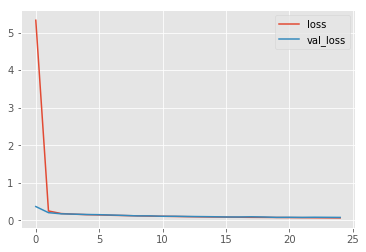

In [27]:
model_sim.fit([data_pairs[:, 0], data_pairs[:, 1]], 
               labels, 
               batch_size       = 24, 
               verbose          = 0, 
               epochs           = 25, 
               callbacks        = [tut_func.PlotLosses()], 
               validation_split = 0.1);

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [28]:
similar(model_sim, 33)

track_id                                  637McrDyDQ9CffkFuZGRpq
artist_name                                                KSHMR
title                                                    Kolkata
album_name                                               Kolkata
label                                                     Dharma
duration                                                  206250
popularity                                                    54
year                                                        2017
genres         [big room, deep big room, edm, electro house, ...
playlist                                               clubbeats
Name: 33, dtype: object


,artist_name,title,album_name,year,playlist
33,KSHMR,Kolkata,Kolkata,2017,clubbeats
58,David Tort,Yo Te Prefiero (feat. Dennisse Jackson),Yo Te Prefiero (feat. Dennisse Jackson),2018,clubbeats
26,Noise Cans,No War (feat. Jesse Royal) - Yellow Claw Remix,No War (feat. Jesse Royal) [Yellow Claw Remix],2017,clubbeats
9,Monik,Palkia,Palkia,2016,clubbeats
36,Hardwell,Safari,Safari,2018,clubbeats
37,Dropgun,Little Drop,Little Drop,2017,clubbeats
32,Dylan Taylor,Frankenstein,Frankenstein,2018,clubbeats
3,J Balvin,Mi Gente - Hardwell & Quintino Remix,Mi Gente (Hardwell & Quintino Remix),2017,clubbeats
304,The Him,Everybody Hurts,Everybody Hurts,2017,electropop
48,TV Noise,Milkshake,Milkshake,2018,clubbeats


General model evaluation:

In [ ]:
evaluate(lambda x,y: [model_sim.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

### Discussion of Results

Although the performance of the evaluation has dropped significantly, the ranked result-lists seem to be more appropriate. From an acoustic similarity point of view, the improved model seems to fit better to track-based music similarity.

# Improve Performance through Identity

So far we have taught the network what is similar and what not, but we have not shown it, what is identical. All input pairs created so far missed to pass identical data. In the following step, we will include identical pairs into the training instances. To emphasis the identity, only identical pairs will be assigned a label of 1. All other similarity values of the lookup-table will be decreased by 0.1. Thus, tracks of the same playlist will have a similarity value 0f 0.9.

In [29]:
def create_pairs_with_sims_and_identity(feature_data, metadata, num_pairs_per_track, playlist_similarities):
    
    data_pairs = []
    labels     = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        # identical pair
        data_pairs.append([feature_data[[row_id]][0], feature_data[[row_id]][0]])
        labels.append(1)
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            
            # similar pair
            data_pairs.append([feature_data[[row_id]][0], feature_data[[pos_example.index]][0]])
            sim_val = playlist_similarities.loc[q_track.playlist, pos_example.playlist] - 0.1
            labels.append(np.max([0, sim_val]))

            # dissimilar pair
            data_pairs.append([feature_data[[row_id]][0], feature_data[[neg_example.index]][0]])
            sim_val = playlist_similarities.loc[q_track.playlist, neg_example.playlist] - 0.1
            labels.append(np.max([0, sim_val]))

    return np.array(data_pairs), np.array(labels)

Execute the function to prepare the data:

In [30]:
data_pairs, labels = create_pairs_with_sims_and_identity(feature_data, metadata, 10, playlist_similarities)

Prepare the Neural Network

In [31]:
# define the model
model_sim_id = create_siamese_network(data_pairs[:,0].shape[1:])

# define the optimizer
opt = Nadam(lr=0.001)

# compile the model
model_sim_id.compile(loss      = contrastive_loss, 
                  optimizer = opt)

Train the model on the adapted data

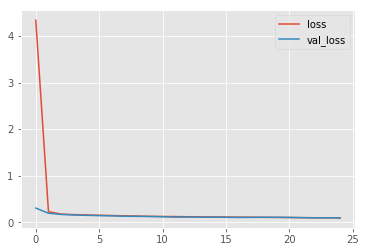

In [32]:
model_sim_id.fit([data_pairs[:, 0], data_pairs[:, 1]], 
               labels, 
               batch_size       = 24, 
               verbose          = 0, 
               epochs           = 25, 
               callbacks        = [tut_func.PlotLosses()], 
               validation_split = 0.1);

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [33]:
similar(model_sim_id, 33)

track_id                                  637McrDyDQ9CffkFuZGRpq
artist_name                                                KSHMR
title                                                    Kolkata
album_name                                               Kolkata
label                                                     Dharma
duration                                                  206250
popularity                                                    54
year                                                        2017
genres         [big room, deep big room, edm, electro house, ...
playlist                                               clubbeats
Name: 33, dtype: object


,artist_name,title,album_name,year,playlist
33,KSHMR,Kolkata,Kolkata,2017,clubbeats
79,Sander van Doorn,Riff - SvD x David Tort Remix,Riff (SvD x David Tort Remix),2017,clubbeats
52,Mike Williams,Step Up,Step Up,2017,clubbeats
16,Hardwell,Get Low,Get Low,2018,clubbeats
25,Galantis,Rich Boy - Quintino Remix,Rich Boy (Remixes),2017,clubbeats
34,Garmiani,Fogo,Fogo,2017,clubbeats
22,Maeva Carter,Escape,Escape,2018,clubbeats
14,Armin van Buuren,My Symphony (The Best Of Armin Only Anthem),My Symphony (The Best Of Armin Only Anthem),2017,clubbeats
32,Dylan Taylor,Frankenstein,Frankenstein,2018,clubbeats
60,Alejandro Diego,Underground,Underground,2017,clubbeats


General model evaluation:

In [ ]:
evaluate(lambda x,y: [model_sim_id.predict([x[[i]], y]) for i in range(feature_data.shape[0])], 20)

### Discussion of Results

Now the model can differentiate between highly and somehow similar.

# Using LSTMs to train on Sequential Data

So long we have by large ignored the temporal information provided by the Spotify features. As mentioned in the first part of the tutorial, these features are extracted from segmented audio data. For each of these segments a feature vector is provided. So far we have aggregated this information into a single vector by calculating statistical values to abstract from the temporal representation and create a general descriptor for the entire track.

In the following part we will harness this temporal information. Recurrent Neural Networks are perfect for analysing sequential data. We will be using the Long Short-Term Memory (LSTM) to train our model on the sequential data.

### Preparing input-data for the LSTM

Now it gets a little more complicated. LSTMs do not take a single input vector as input, but sequences of vectors, also referred to as timesteps. In this tutorial a timestep corresponds with a segment provided by the Spotify API. Such a segment contains the same features used before, but on a smaller temporal scale. We will again caoncatenate those features into a single vector and use several consecutive segments as input for the LSTM.

Unfortunately, du to the onset detection used by Spotify to segment the audio data, these segments do not have the same length. The following chart shows the distribution of the segment length's:

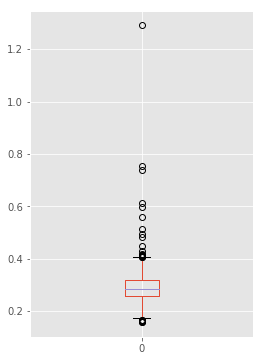

In [34]:
segment_lengths = []

for _, spotify_data in raw_track_data:
    
    _, _, _, f_sequential, f_trackbased = spotify_data
    segment_lengths.append((f_trackbased[0]["duration_ms"] / 1000.) / len(f_sequential["segments"]))

# plot the distribution
pd.DataFrame(segment_lengths).boxplot(figsize=(4,6));

It can be seen, that those vary quite strong between 0.2 and 0.4 seconds. This is a problem when we use a fixed number of segments. For example, the analyzed time-span of 20 segments could range from 4 to 8 seconds. This has an effect on the represented tempo of a track and the model would learn a distorted representation of music similarity. Thus, we will rescale the featurespace using interpolation.

Additionally to the sequential features, the track based features will be used too as an additional input to the neural network.

In [35]:
def aggregate_features_sequential(seq_data, track_data, len_segment_frames, len_segment_sec, m_data, with_year=False, with_popularity=False):
    
    # sequential data
    segments = seq_data["segments"]
    sl       = len(segments)
    
    mfcc              = np.array([s["timbre"]            for s in segments])
    chroma            = np.array([s["pitches"]           for s in segments])
    loudness_max      = np.array([s["loudness_max"]      for s in segments]).reshape((sl,1))
    loudness_start    = np.array([s["loudness_start"]    for s in segments]).reshape((sl,1))
    loudness_max_time = np.array([s["loudness_max_time"] for s in segments]).reshape((sl,1))
    duration          = np.array([s["duration"]          for s in segments]).reshape((sl,1))
    confidence        = np.array([s["confidence"]        for s in segments]).reshape((sl,1))
        
    # concatenate sequential features
    sequential_features = np.concatenate([mfcc, chroma, loudness_max, loudness_start, 
                                          loudness_max_time, duration, confidence], axis=1)

    # calculate length of segment (in ms)
    length_of_track        = track_data[0]["duration_ms"] / 1000.
    length_of_segment      = length_of_track / len(segments)
    num_segments_for_n_sek = int(np.round(len_segment_sec / length_of_segment))
    
    # select a random lstm-input-segment from the aggregated feature data
    offset  = np.random.randint(0, sl - num_segments_for_n_sek)
    segment = sequential_features[offset:(offset+num_segments_for_n_sek),:]
    
    # re-scale segment length to desired length (in seconds)
    x  = np.arange(segment.shape[0])
    y  = np.arange(segment.shape[1])
    xx = np.linspace(x.min(),x.max(),len_segment_frames)

    newKernel = RectBivariateSpline(x,y,segment, kx=2,ky=2)
    segment   = newKernel(xx,y)
        
    # track-based data
    track_features = [track_data[0]["acousticness"],     # acoustic or not?
                      track_data[0]["danceability"],     # danceable?
                      track_data[0]["energy"],           # energetic or calm?
                      track_data[0]["instrumentalness"], # is somebody singing?
                      track_data[0]["liveness"],         # live or studio?
                      track_data[0]["speechiness"],      # rap or singing?
                      track_data[0]["tempo"],            # slow or fast?
                      track_data[0]["time_signature"],   # 3/4, 4/4, 6/8, etc.
                      track_data[0]["valence"]]          # happy or sad?
    
    if with_year:
        track_features.append(int(m_data["year"]))
        
    if with_popularity:
        track_features.append(int(m_data["popularity"]))
        
    
    return segment, track_features


Now lets prepare the input features. We will be using the following parameters

In [36]:
# number of input-vectors for the LSTM
len_segment_frames = 24

# number of seconds these vectors describe
len_segment_sec    = 6.

execute the function to prepare the data:

In [37]:
sequential_features = []
trackbased_features = []

for i, (_, spotify_data) in enumerate(raw_track_data):
    
    _, _, _, f_sequential, f_trackbased = spotify_data
    
    seq_feat, track_feat = aggregate_features_sequential(f_sequential, 
                                                         f_trackbased, 
                                                         len_segment_frames,
                                                         len_segment_sec,
                                                         metadata.loc[i],
                                                         with_year=True,
                                                         with_popularity=True)
    
    sequential_features.append(seq_feat)
    trackbased_features.append(track_feat)
    
sequential_features = np.asarray(sequential_features)
trackbased_features = np.asarray(trackbased_features)

print("sequential_features.shape:", sequential_features.shape)
print("trackbased_features.shape:", trackbased_features.shape)

sequential_features.shape: (1060, 24, 29)
trackbased_features.shape: (1060, 11)


### Normalization

As in the examples before, we need to normalize the data before using it with the neural networks

In [38]:
# standardize sequential_features
rows, x, y = sequential_features.shape
sequential_features  = sequential_features.reshape(rows, (x * y))
sequential_features -= sequential_features.mean(axis=0)
sequential_features /= sequential_features.std(axis=0)
sequential_features  = sequential_features.reshape(rows, x, y)

# standardize trackbased_features
trackbased_features -= trackbased_features.mean(axis=0)
trackbased_features /= trackbased_features.std(axis=0)

### Create Data-Pairs

Also like before, we have to prepare the paired training examples. We continue with the last approach presented in this part, which is based on the mutual similarities and includes identities. Each pair contains the sequential and track-based inputs.

In [39]:
def create_pairs_with_sims_and_identity_segments(sequential_features, trackbased_features, metadata, num_pairs_per_track, playlist_similarities):
    
    data_pairs_seq   = []
    data_pairs_track = []
    labels           = []
    
    for row_id, q_track in metadata.sample(frac=1).iterrows():
        
        data_pairs_seq.append([sequential_features[[row_id]][0], sequential_features[[row_id]][0]])
        data_pairs_track.append([trackbased_features[[row_id]][0], trackbased_features[[row_id]][0]])
        labels.append(1)
        
        for _ in range(num_pairs_per_track):
            
            # search similar and dissimilar examples
            pos_example = metadata[metadata.playlist == q_track.playlist].sample(1)
            neg_example = metadata[metadata.playlist != q_track.playlist].sample(1)

            # create feature pairs
            data_pairs_seq.append([sequential_features[[row_id]][0],   
                                   sequential_features[[pos_example.index]][0]])
            data_pairs_track.append([trackbased_features[[row_id]][0], 
                                     trackbased_features[[pos_example.index]][0]])
            
            sim_val = playlist_similarities.loc[q_track.playlist, pos_example.playlist] - 0.1
            labels.append(np.max([0, sim_val]))

            data_pairs_seq.append([sequential_features[[row_id]][0],   
                                   sequential_features[[neg_example.index]][0]])
            data_pairs_track.append([trackbased_features[[row_id]][0], 
                                     trackbased_features[[neg_example.index]][0]])
            
            sim_val = playlist_similarities.loc[q_track.playlist, neg_example.playlist] - 0.1
            labels.append(np.max([0, sim_val]))

    return np.array(data_pairs_seq), np.array(data_pairs_track), np.asarray(labels)

Execute the function to prepare the results:

In [40]:
data_pairs_seq, data_pairs_track, labels = \
    create_pairs_with_sims_and_identity_segments(sequential_features,
                                                 trackbased_features,
                                                 metadata, 
                                                 10, 
                                                 playlist_similarities)

### The Siamese Network Architecture using LSTMs

The network architecture consists again of shared "twin" layers. But, now two layers are shared. First the fully connected layers which train on the track-based features. Second, a bi-directional LSTM which trains on the re-scaled sequential data provided by the Spotify API. The network thus now takes four inputs. The outputs of the fully connected layer and the LSTM are finally joined and the Eucledian distance of each twin is calculated which is the final output of the model.

In [41]:
def create_siamese_network_with_lstm(data_pairs_seq, data_pairs_track):

    # sequential input
    input_seq_left  = Input(shape=data_pairs_seq[:, 0].shape[1:])
    input_seq_right = Input(shape=data_pairs_seq[:, 0].shape[1:])

    # track-based input
    input_track_left  = Input(shape=data_pairs_track[:, 0].shape[1:])
    input_track_right = Input(shape=data_pairs_track[:, 0].shape[1:])

    # shared bi-directional LSTM layer for the sequential features
    bdlstm = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))

    # shared fully connected layers for the track-based features
    shared_fc_1 = Dense(11, activation="selu")
    shared_fc_2 = Dense(11, activation="selu")   

    # left twin
    seq_resp_left   = bdlstm(input_seq_left)
    track_resp_left = shared_fc_1(shared_fc_2(input_track_left))
    left_twin       = concatenate([seq_resp_left, track_resp_left], axis=1)

    # right twin
    seq_resp_right   = bdlstm(input_seq_right)
    track_resp_right = shared_fc_1(shared_fc_2(input_track_right))
    right_twin       = concatenate([seq_resp_right, track_resp_right], axis=1)

    # calc difference
    distance = Lambda(euclidean_distance,
                      output_shape=lambda x: x[0])([left_twin, right_twin])

    return Model([input_seq_left, input_seq_right, input_track_left, input_track_right], distance)

Prepare the model:

In [ ]:
# define the model
model_rnn = create_siamese_network_with_lstm(data_pairs_seq, data_pairs_track)

# define the optimizer
opt = Nadam(lr=0.001)

# compile the model
model_rnn.compile(loss      = contrastive_loss, 
                  optimizer = opt)

Train the model

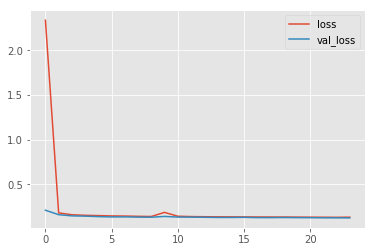

In [ ]:
model_rnn.fit([data_pairs_seq[:, 0],  data_pairs_seq[:, 1], 
               data_pairs_track[:,0], data_pairs_track[:,1]], 
              labels, 
              batch_size       = 24, 
              verbose          = 0, 
              epochs           = 25,
              callbacks        = [tut_func.PlotLosses()], 
              validation_split = 0.1);

### Evaluate by Example

Due to the changed input, we also have to adapt the evaluation function to display example result-lists:

In [ ]:
def similar_rnn(model, query_idx):
    
    print metadata.iloc[query_idx]
    
    # calclulate predicted distances between query track and all others
    res = [model.predict([sequential_features[[query_idx]], sequential_features[[i]], 
                          trackbased_features[[query_idx]], trackbased_features[[i]]]) \
           for i in range(feature_data.shape[0])]

    # reshape
    res = np.array(res)
    res = res.reshape(res.shape[0])

    # get sorted indexes in ascending order (smallest distance to query track first)
    si = np.argsort(res)
    
    # output filter
    display_cols = ["artist_name", "title", "album_name", "year","playlist"]
    
    return metadata.loc[si, display_cols][:10]

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [ ]:
similar_rnn(model_rnn, 330)

In [ ]:
def evaluate(similarity_function, cut_off):

    all_precisions = []
    
    pbar = progressbar.ProgressBar()

    for idx in pbar(metadata.index.values):

        dist           = similarity_function(sequential_features, sequential_features[[idx]], 
                                             trackbased_features, trackbased_features[[idx]])
        
        dist           = np.array(dist).reshape(len(dist))
        
        similar_tracks = metadata.loc[np.argsort(dist)[::-1][:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)

    all_precisions = np.array(all_precisions)

    return all_precisions.mean()

In [ ]:
evaluate(lambda w,x,y,z: [model.predict([w[[i]],x,y[[i]],z]) for i in range(sequential_features.shape[0])], 20)

# Conclusions

In this part of the tutorial I have demonstrated how to use neural networks to train a similarity function. First the model trained on the same aggregated features as used in part one of this tutorial. A huge improvement in performance could be noticed. Further, it was demonstrated how to harness temporal relationships by training LSTMs on the sequential data provided by Spotify.

In the next part of this tutorial series I will demonstrate how to use the so far disregarded genre labels provided by Spotify. I will show how to apply tag-similarity metrics to automatically create the similarity lookup table for the ground-truth. This facilitates more precise input-pairs for the model to train on.